In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from sklearn.model_selection import GridSearchCV
import pandas as pd
from imblearn.over_sampling import SMOTE
from collections import Counter
from datasets import load_dataset
from sklearn.metrics.pairwise import cosine_similarity
import re
import string
import nltk
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
import numpy as np

# Download necessary NLTK data (run this once)
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt')

/home/aaiteam4/anaconda3/envs/resume-ai/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
import xgboost as xgb

In [3]:
from sklearn.impute import SimpleImputer

In [4]:
# 1. Get the dataset from Hugging Face
dataset_name = "cnamuangtoun/resume-job-description-fit"
try:
    dataset = load_dataset(dataset_name)
    df = dataset['train'].to_pandas()
    print(f"Dataset '{dataset_name}' loaded successfully. Shape: {df.shape}")
    print("Column names in the DataFrame:")
    print(df.columns)
    # We need to identify the correct column names for text and labels
    TEXT_COLUMN = None  # We will update this based on the output
    LABEL_COLUMN = None # We will update this based on the output
except Exception as e:
    print(f"Error loading dataset '{dataset_name}': {e}")
    exit()

Dataset 'cnamuangtoun/resume-job-description-fit' loaded successfully. Shape: (6241, 3)
Column names in the DataFrame:
Index(['resume_text', 'job_description_text', 'label'], dtype='object')


In [5]:
# 2. Preprocessing
TEXT_COLUMN_RESUME = 'resume_text'
TEXT_COLUMN_JOB = 'job_description_text'
LABEL_COLUMN = 'label'

stop_words = set(stopwords.words('english'))
custom_stopwords = ['e.g.', 'i.e.', 'etc.', 'the', 'and', 'a', 'an', 'in', 'of', 'to'] # Add more if needed
stop_words.update(custom_stopwords)

def preprocess_text(text):
    if isinstance(text, str):
        # Lowercase
        text = text.lower()
        # Remove email addresses
        text = re.sub(r'\S*@\S*\s?', '', text)
        # Remove non-ASCII characters
        text = re.sub(r'[^\x00-\x7F]+', '', text)
        # Remove numbers (keeping those with % $ or year format)
        text = re.sub(r'(?<!\d)(?<![\$\%])\b\d+\b', '', text)
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Remove stopwords
        text_tokens = text.split()
        filtered_tokens = [w for w in text_tokens if not w in stop_words]
        return " ".join(filtered_tokens)
    return ""

print("Applying preprocessing...")
df['processed_resume'] = df[TEXT_COLUMN_RESUME].apply(preprocess_text)
df['processed_job_description'] = df[TEXT_COLUMN_JOB].apply(preprocess_text)
# Combine processed resume and job description for the model
df['combined_text'] = df['processed_resume'] + ' ' + df['processed_job_description']
df = df[df['combined_text'].str.len() > 0] # Remove rows with empty combined text
print("Preprocessing complete.")

# Encode the categorical labels to numerical values
label_mapping = {'No Fit': 0, 'Potential Fit': 1, 'Good Fit': 2}
df['label_encoded'] = df[LABEL_COLUMN].map(label_mapping)
print(f"Unique labels and their encoding: {label_mapping}")
print(f"Encoded labels: {df['label_encoded'].unique()}")


Applying preprocessing...
Preprocessing complete.
Unique labels and their encoding: {'No Fit': 0, 'Potential Fit': 1, 'Good Fit': 2}
Encoded labels: [0 1 2]


In [6]:
# 3. Sentence-BERT Embedding
model_name = 'all-mpnet-base-v2'
try:
    model = SentenceTransformer(model_name)
    print(f"Sentence-BERT model '{model_name}' loaded.")
    embeddings = model.encode(df['combined_text'].tolist(), show_progress_bar=True, batch_size=16) # Try a smaller batch size
    embeddings_df = pd.DataFrame(embeddings)
    df = pd.concat([df.reset_index(drop=True), embeddings_df], axis=1)
    print("Sentence embeddings generated.")
except Exception as e:
    print(f"Error loading or using Sentence-BERT model '{model_name}': {e}")
    exit()

# Prepare data for the Naive Bayes model
X = df.iloc[:, -768:] # Assuming embeddings are the last 768 columns
y = df['label_encoded']

Sentence-BERT model 'all-mpnet-base-v2' loaded.


Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Sentence embeddings generated.


In [7]:
def calculate_similarity(row):
    resume_embedding = row.iloc[-768:]  # Get the resume embedding
    job_embedding = model.encode(row['processed_job_description']) # Encode job description
    return cosine_similarity([resume_embedding], [job_embedding])[0][0]

print("Calculating cosine similarity between resume and job description...")
df['similarity_score'] = df.apply(calculate_similarity, axis=1)
print("Cosine similarity calculated.")

Calculating cosine similarity between resume and job description...
Cosine similarity calculated.


In [8]:
# Prepare data with the similarity score as a feature
X_with_similarity_rf = pd.concat([df.iloc[:, -769:-1], df['similarity_score']], axis=1)
y_rf = df['label_encoded']

# Convert all column names to strings (important for SMOTE)
X_with_similarity_rf.columns = X_with_similarity_rf.columns.astype(str)

# Split data
X_train_rf_sim, X_test_rf_sim, y_train_rf_sim, y_test_rf_sim = train_test_split(X_with_similarity_rf, y_rf, test_size=0.2, random_state=42)

In [9]:
# Apply SMOTE to the training data
smote_rf_sim = SMOTE(random_state=42)
X_resampled_rf_sim, y_resampled_rf_sim = smote_rf_sim.fit_resample(X_train_rf_sim, y_train_rf_sim)

In [18]:
# Initialize and train the XGBoost model with combined features
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_resampled_rf_sim, y_resampled_rf_sim)  # Use the numerically encoded y_train
xgb_predictions = xgb_model.predict(X_test_rf_sim)

# Evaluate the model with combined features
print("\nXGBoost with SBERT embedding and Cosine Similarity:")
print(classification_report(y_test_rf_sim, xgb_predictions))
print("Accuracy:", accuracy_score(y_test_rf_sim, xgb_predictions))


XGBoost with SBERT embedding and Cosine Similarity:
              precision    recall  f1-score   support

           0       0.66      0.56      0.61       658
           1       0.31      0.35      0.33       288
           2       0.30      0.35      0.32       303

    accuracy                           0.46      1249
   macro avg       0.42      0.42      0.42      1249
weighted avg       0.49      0.46      0.47      1249

Accuracy: 0.46277021617293834


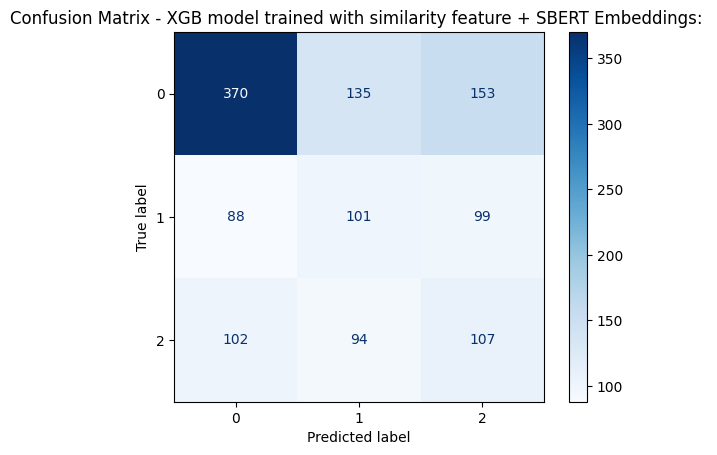

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test_rf_sim, xgb_predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - XGB model trained with similarity feature + SBERT Embeddings: ")
plt.show()